# Identifying Small Mean Reverting Portfolios

This is a replication of the paper "Identifying Small Reverting Portfolios" by Alexandre d'Aspremont (2008) on cryptocurrencies. Specifically, we will be working with the Binance perpetual futures universe as they consists of the most liquid cryptocurrency pairs, have lower fees and have less limitations on short-selling.

Please refer to the paper here: https://arxiv.org/abs/0708.3048

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.covariance import GraphicalLassoCV
from sklearn.linear_model import MultiTaskLasso, Lasso

from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pyfolio as pf

import itertools
import networkx as nx
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import select_order, coint_johansen

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from custom_functions import *

# Load Binance's futures universe

There are a few preprocessing steps to the data.

1. Binance's futures universe consists of dated futures and perpetual futures. We only want to work with perpetual futures, so we remove any tickers with an underscore (e.g. ETHUSDT_2210) as they represent dated futures. 


2. Binance also has pairs denominated in both USDT and BUSD. We only want to keep one of them, so we will remove highly correlated pairs (>99% correlation).


3. Sometimes tickers are delisted from the futures universe. This is reflected when their prices remain constant after they are delisted. To counteract this, we set all values which are the same as a week agos to NaN.

In [3]:
def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)

In [4]:
%%time
df = pd.read_hdf("data.h5", "crypto_futures_daily")
close = df['close'].unstack('ticker').sort_index()
close = close[[i for i in close.columns if "_" not in i]]
close = remove_correlated_assets(close)
close = close[close.ne(close.shift(7))]

CPU times: total: 62.5 ms
Wall time: 61.8 ms


In [5]:
# 80-20 train-test split, hence 8 months for training, 2 months for testing
lookback = 8
os_period = 2

train_start = close.index.min() + pd.DateOffset(months=21)
train_end = train_start + pd.DateOffset(months=lookback)
train = close.loc[train_start:train_end]

test_start = train.index.max() + pd.DateOffset(days=1)
test_end = test_start + pd.DateOffset(months=os_period)
test = close.loc[test_start: test_end]

train_test = close.loc[train_start:test_end].dropna(axis=1)
train = train[train_test.columns]
test = test[train_test.columns]

log_train = train.apply(np.log)
log_test = test.apply(np.log)

In [6]:
print("Training sample start and end date:")
print([train.index.min(), train.index.max()])
print("\n")
print("Testing sample start and end date:")
print([test.index.min(), test.index.max()])
print("\n")
print(f"Number of tickers: {train_test.shape[1]}")

Training sample start and end date:
[Timestamp('2021-12-01 00:00:00'), Timestamp('2022-08-01 00:00:00')]


Testing sample start and end date:
[Timestamp('2022-08-02 00:00:00'), Timestamp('2022-10-01 00:00:00')]


Number of tickers: 82


In [7]:
all_assets = train_test.columns
len(all_assets)

82

# Graphical representation of asset relationships

There are 4 steps to generating optimal mean reverting portfolios from an existing universe.

1. Model asset prices as a Vector AutoRegressive (VAR) model of lag 1, apply L1 regularization (also known as LASSO), transform the matrix of coefficients into a symmetric matrix and find the graphical representation of this matrix.


2. Estimate a sparse inverse covariance matrix (otherwise known as the precision matrix) of asset returns. Rationale being: zeros in an inverse covariance matrix of asset returns indicate conditional independence and vice versa. Find the graphical representation of this matrix.


3. Find the intersection of the two aforementioned graphs, assets with persistent conditional dependencies on each other will form small clusters. An optimal mean reverting portfolio can be formed from within these clusters. 


4. Construct the mean reverting portfolio through canonical analysis (such as the process outlined in Box-Tiao, 1977) or through a Vector Error Correction Model (VECM).

We will start off with the first step.

### 1. L1 regularized VAR(1) matrix of asset prices

In [8]:
# LASSO is sensitive to scale, it is hence recommended to standardize (zero mean and unit variance) before applying LASSO

asset_prices = log_train[all_assets].dropna()
asset_prices = asset_prices.sub(asset_prices.mean(0)).div(asset_prices.std(0))

In [9]:
# There is flexibility in using both univariate LASSO and multivariate LASSO (aka MultiTaskLasso). The difference is the latter
# tends to suppress all coefficients in a columnwise manner

ls = MultiTaskLasso(alpha=0.1) # choice of alpha in the paper
ls.fit(asset_prices.shift()[1:], asset_prices[1:])

MultiTaskLasso(alpha=0.1)

In [10]:
A = pd.DataFrame(ls.coef_, index=all_assets, columns=all_assets)
ATA = A.T@A

In [11]:
ATA = ATA.to_numpy()
np.fill_diagonal(ATA, 0)
ATA = pd.DataFrame(ATA, columns=all_assets, index=all_assets)

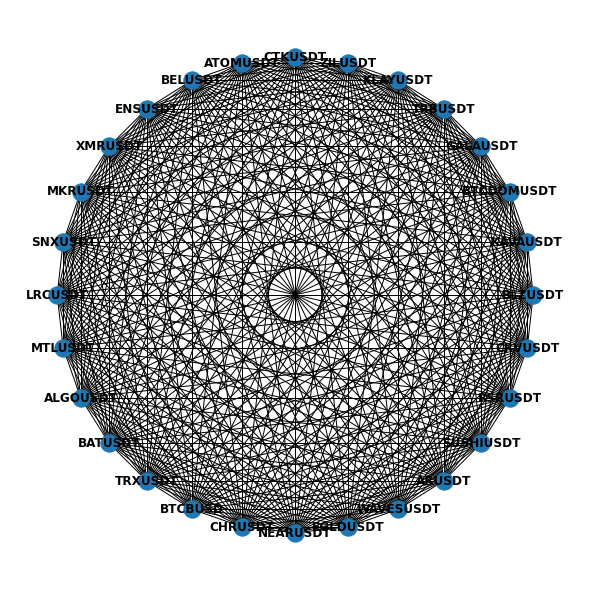

In [12]:
G = nx.Graph(ATA)
G.remove_nodes_from(list(nx.isolates(G)))

plt.figure(figsize=(8, 8))
nx.draw_shell(G, with_labels=True, font_weight='bold')

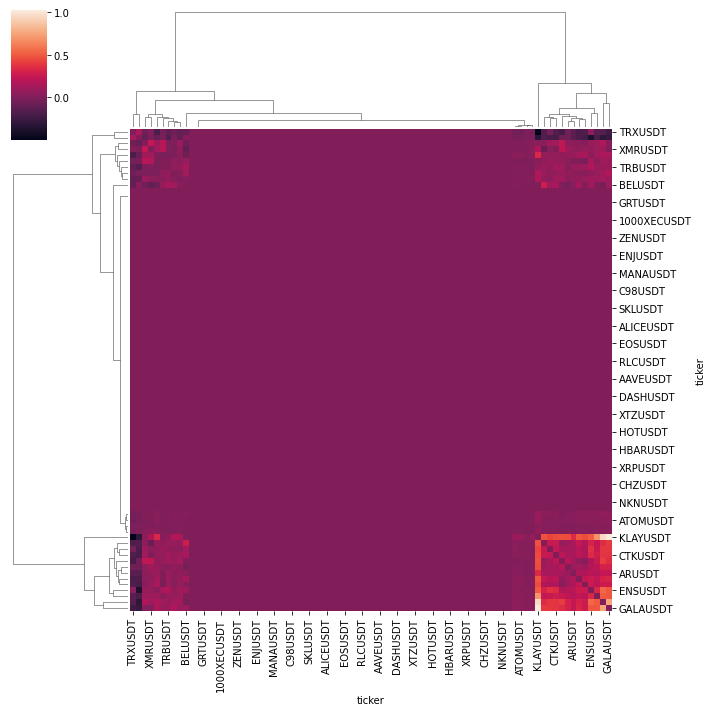

In [13]:
# From the clustermap, we can indeed see that a L1 regularized VAR(1) model does indeed give us sparse estimates of the coefficients
sns.clustermap(ATA, square=True, method="ward");

### 2. Sparse L1 regularized precision matrix of asset returns

In [14]:
asset_returns = asset_prices.diff().iloc[1:, :]
asset_returns = asset_returns.sub(asset_returns.mean(0)).div(asset_returns.std(0))

In [15]:
# We will use cross-validation to determine alpha here, this is conveniently done through the sklearn library
edge_model = GraphicalLassoCV(n_jobs=-1)
edge_model.fit(asset_returns)

GraphicalLassoCV(n_jobs=-1)

In [16]:
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
partial_correlations *= -1
np.fill_diagonal(partial_correlations, 0)

In [17]:
partial_correlations = pd.DataFrame(partial_correlations, columns=asset_returns.columns, index=asset_returns.columns)

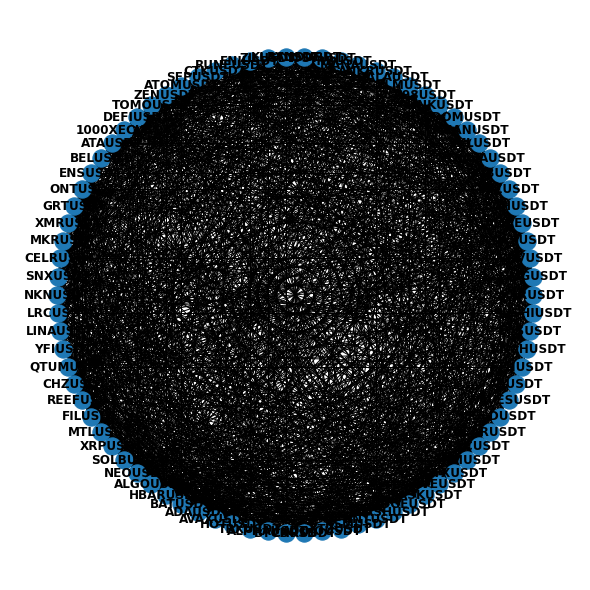

In [18]:
H = nx.Graph(partial_correlations)
H.remove_nodes_from(list(nx.isolates(H)))

plt.figure(figsize=(8, 8))
nx.draw_shell(H, with_labels=True, font_weight='bold')

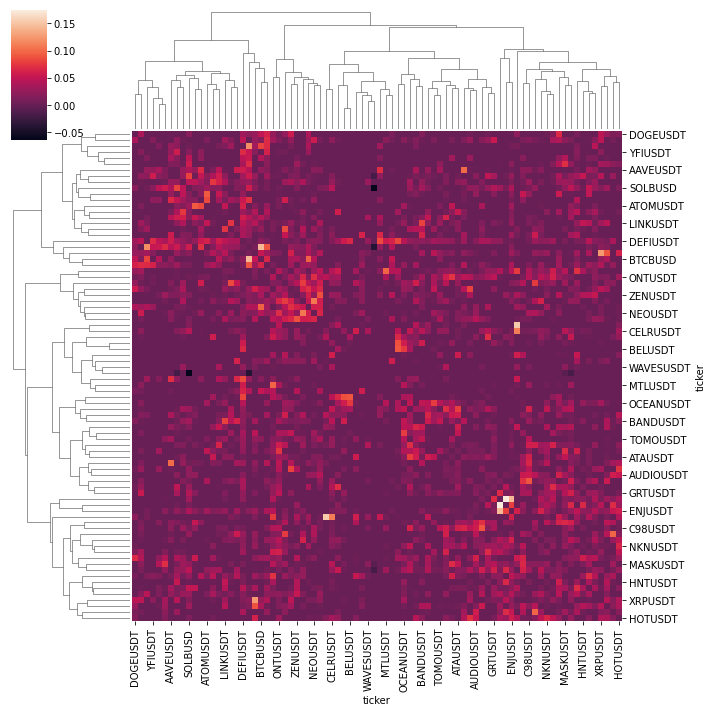

In [19]:
sns.clustermap(partial_correlations, square=True, method="ward");

An alternative way to view the clusters generated by graphical LASSO is through hierarchical clustering, as demonstrated below:

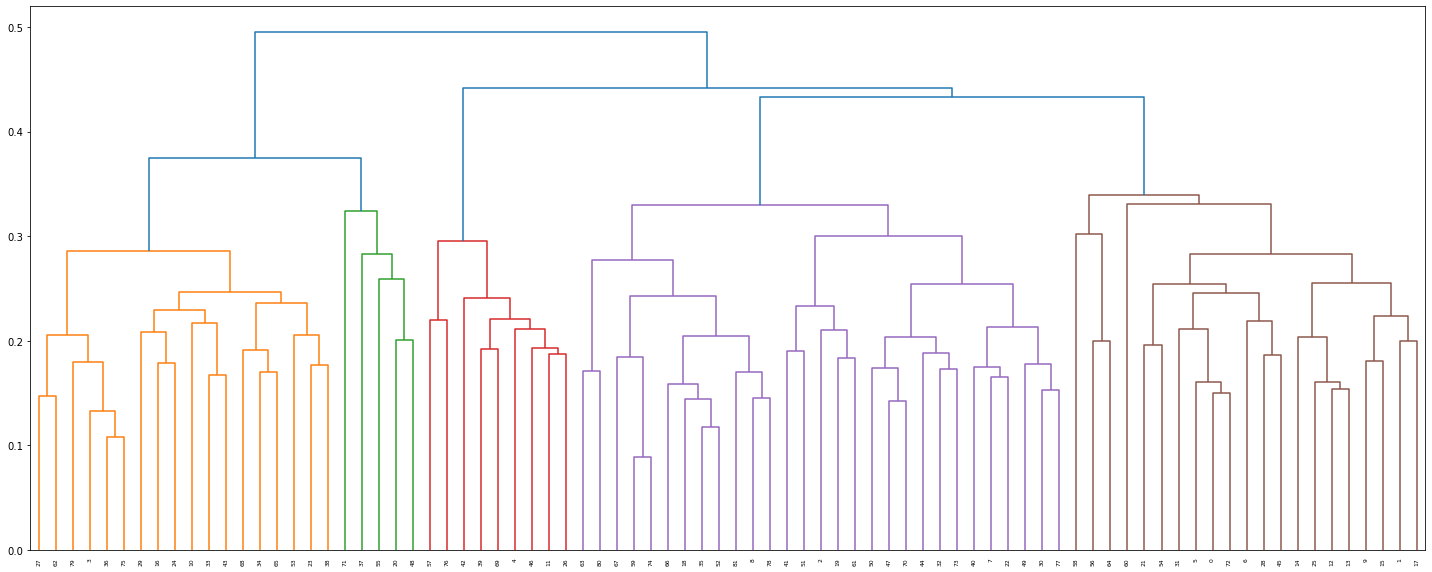

In [20]:
Z = linkage(partial_correlations, method="ward")
threshold = 0.7*max(Z[:, 2]) # default
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, color_threshold=threshold)
plt.show()

In [21]:
names = partial_correlations.columns
labels = fcluster(Z, threshold, criterion="distance")
n_labels = labels.max()

cluster_map = {}
cluster_size = []
for i in range(1, n_labels+1):
    print(f"Cluster {i}: {', '.join(names[labels == i])}")
    print("\n")
    cluster_map[i] = names[labels == i].values
    cluster_size.append(len(cluster_map[i]))

Cluster 1: YFIUSDT, SOLBUSD, AVAXUSDT, XTZUSDT, KSMUSDT, DOGEUSDT, AAVEUSDT, NEARUSDT, EGLDUSDT, ARUSDT, 1INCHUSDT, CRVUSDT, LINKUSDT, KLAYUSDT, RUNEUSDT, ATOMUSDT, ENSUSDT, MKRUSDT


Cluster 2: BTCBUSD, ETHUSDT, BNBUSDT, XLMUSDT, DEFIUSDT


Cluster 3: QTUMUSDT, NEOUSDT, DASHUSDT, EOSUSDT, OMGUSDT, BCHUSDT, ANKRUSDT, ZENUSDT, ONTUSDT


Cluster 4: LINAUSDT, FILUSDT, MTLUSDT, TRXUSDT, ALPHAUSDT, AUDIOUSDT, IOTXUSDT, RLCUSDT, WAVESUSDT, SUSHIUSDT, RSRUSDT, ICXUSDT, BLZUSDT, KAVAUSDT, SKLUSDT, OCEANUSDT, BTCDOMUSDT, TRBUSDT, BANDUSDT, ZILUSDT, CTKUSDT, SFPUSDT, TOMOUSDT, ATAUSDT, BELUSDT, GRTUSDT, XMRUSDT, CELRUSDT, SNXUSDT


Cluster 5: NKNUSDT, LRCUSDT, CHZUSDT, REEFUSDT, XRPUSDT, ALGOUSDT, HBARUSDT, BATUSDT, ADAUSDT, HOTUSDT, CHRUSDT, HNTUSDT, MASKUSDT, SRMUSDT, ALICEUSDT, C98USDT, GALAUSDT, MANAUSDT, IOSTUSDT, ENJUSDT, 1000XECUSDT




### 3. Extracting persistent conditional dependencies through the intersection of both graphs

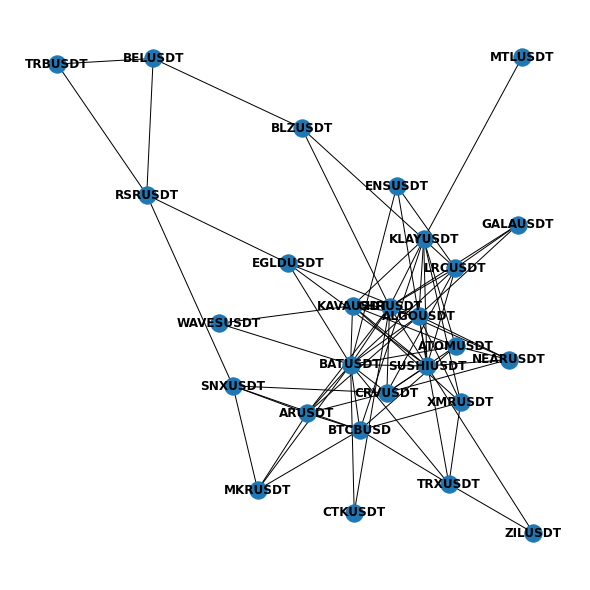

In [22]:
R = nx.intersection(G, H)
R.remove_nodes_from(list(nx.isolates(R)))
    
pos = nx.spring_layout(R, seed = 0)
plt.figure(figsize=(8, 8))
nx.draw(R, pos=pos, with_labels=True, font_weight='bold')

In [23]:
# We will work with the largest cluster

subgraphs = [R.subgraph(c) for c in nx.connected_components(R)]
n_subgraphs = len(subgraphs)
max_nodes = subgraph_idx = 0
for i in range(n_subgraphs):
    print(f"Subgraph {i} consists of {subgraphs[i].nodes()}")
    num_nodes = len(subgraphs[i].nodes())
    if num_nodes > max_nodes:
        subgraph_idx = i
        max_nodes = num_nodes

Subgraph 0 consists of ['MKRUSDT', 'ARUSDT', 'CTKUSDT', 'ENSUSDT', 'NEARUSDT', 'SUSHIUSDT', 'RSRUSDT', 'BATUSDT', 'ALGOUSDT', 'KLAYUSDT', 'CRVUSDT', 'WAVESUSDT', 'BLZUSDT', 'BELUSDT', 'XMRUSDT', 'KAVAUSDT', 'TRBUSDT', 'EGLDUSDT', 'MTLUSDT', 'TRXUSDT', 'SNXUSDT', 'CHRUSDT', 'ATOMUSDT', 'BTCBUSD', 'ZILUSDT', 'LRCUSDT', 'GALAUSDT']


In [24]:
S = subgraphs[subgraph_idx]

In [25]:
optimal_assets = list(nx.nodes(S))
print(len(optimal_assets))

27


# Forming the mean-reverting portfolio

After having identified optimal clusters to form mean reverting portfolios from, how can we then actually form the portfolio? As detailed above, there are 2 methods: Canonical Analysis and VECM. However, even using all assets in the small clusters may not be ideal. Hence, we have to form the optimal portfolio by maximizing/minimizing a preferred metric.

There are 3 metrics used in this notebook. Here, I use the metric proposed in the paper, that is the predictability. However, there are 2 other metrics that can be considered, as listed below:

1. Portmanteau statistic
2. Crossing statistic
3. Predictability

For a more in-depth and mathematical intuition of the metrics, please head over to Hudson and Thames where they provide a great explanation: https://hudsonthames.org/sparse-mean-reverting-portfolio-selection/

We use greedy selection to recursively select the asset that minimizes the predictability of our portfolio until we reach a minimum. This is not a serious disadvantage as Fogarasi (2012) found that brute force search was only able to produce a stronger mean-reverting portfolio 59.3% of the time. This is an adequate trade-off for computing speed vs results.

## Box-Tiao Canonical Decomposition (BTCD)

We start off with Canonical Analysis.

In [26]:
current_num = 0 # current number of assets in our portfolio
portfolio_minimum = np.inf # minimum statistic of our portfolio
portfolio_assets = [] # current assets in our portfolio

asset_prices = close[optimal_assets].dropna()
while len(optimal_assets) > 0:
    if current_num > 0:
        min_stat = np.inf # initialize local minimum stat
        for asset in optimal_assets: # loop through each asset in our list of optimal assets
            current_assets = portfolio_assets + [asset] # current assets are just the assets in our portfolio + asset we are looping through
            log_prices = asset_prices[current_assets].dropna().apply(np.log)
            is_prices = log_prices[train_start:train_end]
            is_prices = is_prices.sub(is_prices.mean(axis=0))

            beta = BTCD(is_prices)
            beta = beta.div(beta.abs().sum(0))
            beta = beta.div(beta.iloc[0, :])
            beta = beta.div(beta.abs().sum(axis=0))

            spreads = pd.DataFrame(log_prices.to_numpy()@beta.to_numpy(), index=log_prices.index)
            spreads = spreads[train_start:test_end].sub(spreads[:train_end].mean(axis=0))
            z_scores = spreads.div(spreads[:train_end].std(axis=0))
            
            pred_stat = predictability_statistic(z_scores[:train_end])
            stat_df = pd.DataFrame(pred_stat).rename(columns={0: "Predictability statistic"})
            sorted_stats = stat_df["Predictability statistic"].sort_values()

            current_min_idx = sorted_stats.index[0]
            current_min = sorted_stats[current_min_idx]

            if current_min < min_stat: # if the current minimum statistic is lower than local minimum statistic
                shortlisted_asset = asset # the shortlisted asset becomes the current asset
                min_stat = current_min # the local minimum statistic becomes the current minimum statistic

        if portfolio_minimum < min_stat and len(portfolio_assets) >= 2: # if the portfolio minimum does not decrease with local minimum, break the loop
            print("Optimal portfolio formed.")
            break
        else:
            portfolio_minimum = min_stat # the portfolio minimum is then the local minimum
            optimal_assets.remove(shortlisted_asset) # remove the shortlisted asset from our list of optimal assets
            portfolio_assets.append(shortlisted_asset) # add it to our portfolio
            current_num += 1 # increase the number of assets in our portfolio by 1

        print(f"Number of assets in portfolio {len(portfolio_assets)}")
        print(f"Number of remaining assets: {len(optimal_assets)}")
        print("\n")
        
        if len(optimal_assets) == 0:
            print("Optimal portfolio formed.")
            break
            
    elif current_num == 0:
        min_stat = np.inf # initialize local minimum stat
        for asset in optimal_assets: # loop through each asset in our list of optimal assets    
            log_prices = asset_prices[asset].to_frame().dropna().apply(np.log)
            is_prices = log_prices[train_start:train_end]
            is_prices = is_prices.sub(is_prices.mean(axis=0))

            spreads = is_prices.copy() # the spread is just the log price of the asset
            z_scores = spreads.div(spreads[:train_end].std(axis=0))
            current_min = predictability_statistic(z_scores[:train_end])[0]

            if current_min < min_stat: # if the current minimum statistic is lower than local minimum statistic
                shortlisted_asset = asset # the shortlisted asset becomes the current asset
                min_stat = current_min # the local minimum statistic becomes the current minimum statistic

        portfolio_minimum = min_stat # the portfolio minimum is then the local minimum
        optimal_assets.remove(shortlisted_asset) # remove the shortlisted asset from our list of optimal assets
        portfolio_assets.append(shortlisted_asset) # add it to our portfolio
        current_num += 1 # increase the number of assets in our portfolio by 1
        
        print(f"Number of assets in portfolio {len(portfolio_assets)}")
        print(f"Number of remaining assets: {len(optimal_assets)}")
        print("\n")

Number of assets in portfolio 1
Number of remaining assets: 26


Number of assets in portfolio 2
Number of remaining assets: 25


Number of assets in portfolio 3
Number of remaining assets: 24


Number of assets in portfolio 4
Number of remaining assets: 23


Number of assets in portfolio 5
Number of remaining assets: 22


Number of assets in portfolio 6
Number of remaining assets: 21


Number of assets in portfolio 7
Number of remaining assets: 20


Number of assets in portfolio 8
Number of remaining assets: 19


Number of assets in portfolio 9
Number of remaining assets: 18


Number of assets in portfolio 10
Number of remaining assets: 17


Number of assets in portfolio 11
Number of remaining assets: 16


Number of assets in portfolio 12
Number of remaining assets: 15


Number of assets in portfolio 13
Number of remaining assets: 14


Number of assets in portfolio 14
Number of remaining assets: 13


Number of assets in portfolio 15
Number of remaining assets: 12


Number of assets in

In [27]:
log_prices = close[portfolio_assets].dropna().apply(np.log)
is_prices = log_prices[train_start:train_end]
is_prices = is_prices.sub(is_prices.mean(axis=0))

In [28]:
# Normalizing weights such that the absolute values sum up to 1. This guarantees a leverage of 1 in our long-short portfolio.
beta = BTCD(is_prices) # Box-Tiao Canonical Decomposition
beta = beta.div(beta.abs().sum(0))
beta = beta.div(beta.iloc[0, :])
beta = beta.div(beta.abs().sum(axis=0))
beta

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
ticker,,,,,,,,,,,,,,,,,,,,,
TRXUSDT,0.176656,0.035114,0.065331,0.033736,0.030666,0.083269,0.017110,0.020326,0.039443,0.062889,...,0.008618,0.041755,0.075690,0.017910,0.011474,0.049003,0.021754,0.081937,0.047860,0.017019
SNXUSDT,0.002326,0.025430,0.041970,-0.110357,-0.054281,0.044326,-0.071798,-0.009750,0.049431,0.171168,...,0.017363,-0.045477,-0.093564,0.053929,0.030769,-0.047109,0.009458,-0.013785,-0.028532,-0.020594
ENSUSDT,-0.036062,0.009450,-0.035195,-0.000006,-0.008692,-0.032284,0.059990,0.061365,0.133478,-0.046061,...,-0.005943,-0.100374,-0.007744,0.032919,0.067491,-0.039821,0.031871,0.101399,0.112128,-0.035738
ZILUSDT,-0.013448,0.000297,-0.017623,0.011285,-0.049604,0.032158,0.041822,0.063628,-0.031290,-0.038120,...,0.074600,0.098884,-0.036690,0.043824,-0.060308,-0.131678,0.087266,0.091973,-0.066046,0.016314
CHRUSDT,-0.020350,0.002382,0.111747,0.070287,-0.025060,-0.135665,0.001457,-0.029361,0.044467,0.033280,...,-0.047668,0.014376,0.042489,0.059070,-0.068543,-0.036323,0.056266,-0.049986,0.015119,-0.062270
XMRUSDT,-0.062489,-0.025854,0.024489,-0.093599,0.021758,0.039093,0.059390,-0.042745,-0.014126,-0.004750,...,-0.168780,0.006663,0.027293,-0.066844,0.034188,-0.002279,0.055085,0.068475,-0.048107,0.004994
MTLUSDT,0.047934,0.025129,0.031533,0.123434,-0.008213,0.026036,-0.109297,0.012065,-0.048906,-0.025337,...,-0.079659,-0.110726,-0.058581,-0.077153,-0.028089,-0.069361,0.008059,0.056369,-0.016935,0.002298
NEARUSDT,0.077145,0.026154,-0.041380,-0.033357,0.045172,-0.018991,0.008413,-0.067504,0.101090,-0.004556,...,0.021876,-0.011746,0.039419,-0.085112,-0.023911,-0.040194,0.108310,-0.037183,-0.104199,-0.052852
TRBUSDT,0.041405,0.073494,0.004813,0.035508,0.000055,-0.001709,0.007085,-0.137721,0.004842,-0.071937,...,0.003483,0.088665,-0.073538,-0.003989,0.131998,-0.064048,-0.025201,-0.028521,0.046550,-0.028362


In [29]:
spreads = pd.DataFrame(log_prices.to_numpy()@beta.to_numpy(), index=log_prices.index)
spreads = spreads[train_start:test_end].sub(spreads[train_start:train_end].mean(axis=0))
z_scores = spreads.div(spreads[train_start:train_end].std(axis=0))
z_scores

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01,1.901807,-3.182224,2.704131,2.362283,-0.075232,1.481789,0.331213,-2.080161,1.330244,1.775642,...,-2.345031,1.422191,-2.319298,0.791933,0.267499,-2.094172,-1.140647,2.809366,1.845372,-1.721202
2021-12-02,1.873168,-1.650324,2.326444,2.116727,-0.345296,2.128054,-0.071106,-1.121600,1.403033,1.486331,...,-2.679619,1.389741,-2.069750,0.631371,0.242637,-2.101206,-1.103762,2.561480,1.834341,-1.643731
2021-12-03,3.030564,-2.825193,0.052144,1.800466,-1.284599,1.942677,0.084667,-0.586455,1.437438,1.341116,...,-2.523789,0.993280,-1.584308,0.469208,0.299248,-2.063841,-1.150571,2.075528,1.557396,-1.546615
2021-12-04,1.350133,1.406803,-0.444720,0.167104,-2.880789,1.567481,0.761752,-0.382203,0.969358,0.767787,...,-1.693904,0.461441,-1.436142,0.634454,0.103018,-1.264924,-1.049121,1.973254,1.574519,-1.347884
2021-12-05,0.336218,1.801599,-0.723532,-0.674142,-2.278824,1.613158,-0.482365,-1.137216,0.750308,0.216947,...,-1.074228,0.109537,-0.787319,1.112646,0.355711,-1.041675,-1.041300,2.031910,1.527371,-1.218189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27,-2.277546,0.370166,-2.600418,-1.891095,5.485582,2.413219,7.242360,0.133088,-0.335666,-3.437694,...,1.039778,-3.177556,-0.704191,1.162480,0.767341,0.992301,-0.236076,-1.939130,1.216084,1.466655
2022-09-28,-2.363386,0.344684,-2.397637,-2.355993,5.313783,2.202058,6.959364,-0.271861,-0.184933,-3.023490,...,1.109280,-3.185420,-0.976570,1.108859,1.029543,0.947294,-0.197553,-1.871528,1.262891,1.468321
2022-09-29,-2.238904,-0.081744,-2.238823,-2.149036,4.930576,2.275182,6.870361,-0.544462,-0.146316,-3.039970,...,1.084417,-3.184531,-0.864919,1.087275,0.905985,0.976880,-0.186401,-1.802620,1.251411,1.473335


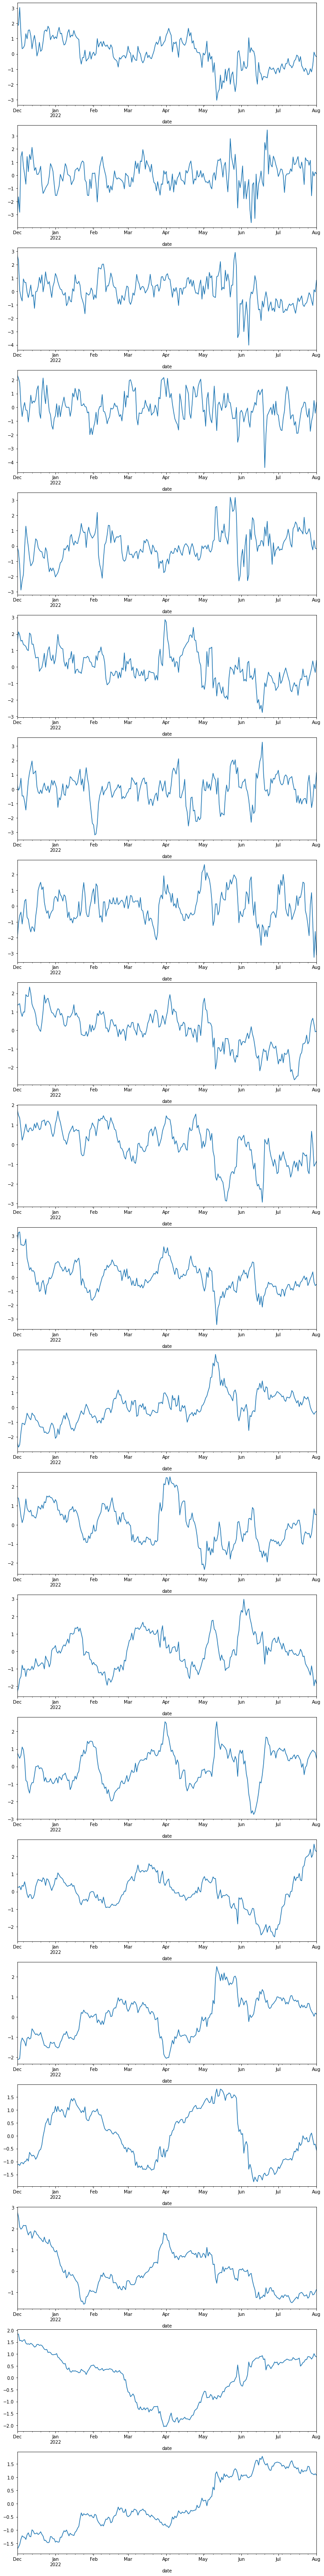

In [30]:
fig, ax = plt.subplots(z_scores.shape[1], 1, figsize=(12, z_scores.shape[1]*5))
for i in range(z_scores.shape[1]):
    z_scores[i][train_start:train_end].plot(ax=ax[i]);

We can see that Canonical Analysis is working as it should: Solving a generalized eigenvector problem to produce a selection of portfolios that range from being unpredictable to predictable. However, we have no need for predictable portfolios in a mean-reverting strategy. Hence, we test these portfolios and remove any that are not stationary.

For the stationary portfolios, we generate the portmanteau statistic, crossing statistic, and drift statistic, which is a adapted metric from regressing a time trend against the portfolio. Rationale being: we want the most stable and mean reverting portfolio spread to trade.

In [31]:
port_stat, indices = [], []
for i in range(z_scores.shape[1]):
    s = z_scores.iloc[:, i][:train_end].values
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        if stationarity_test(s):
            ps = portmanteau_statistic(s)
            port_stat.append(ps)
            indices.append(i)

stat_df = pd.DataFrame(port_stat, index=indices).rename(columns={0: "Portmanteau statistic"})
stat_df["Crossing statistic"] = crossing_statistic(z_scores[:train_end][stat_df.index])
stat_df["Predictability statistic"] = predictability_statistic(z_scores[:train_end][stat_df.index])
stat_df["Drift statistic"] = drift_statistic(z_scores[:train_end][stat_df.index])
stat_df = stat_df.dropna()
stat_df

,Portmanteau statistic,Crossing statistic,Predictability statistic,Drift statistic
0,690.620354,6.015149,0.254204,0.111111
1,115.950716,3.057773,0.200216,0.026144
2,212.979142,3.735995,0.329531,0.071895
3,136.737348,3.528649,0.346259,0.045752
4,262.191604,4.395719,0.438730,0.065359
5,523.043063,5.773480,0.513245,0.091503
6,265.359222,4.655482,0.566187,0.019608
7,270.985556,4.739601,0.592821,0.013072
8,789.490432,8.070989,0.766197,0.117647
9,700.305518,7.887708,0.740789,0.104575


In [32]:
sorted_stats = stat_df.prod(axis=1).sort_values()
best_idx = sorted_stats.index[0]
print(f"Most statistically suitable eigenportfolio: {best_idx}")

Most statistically suitable eigenportfolio: 1


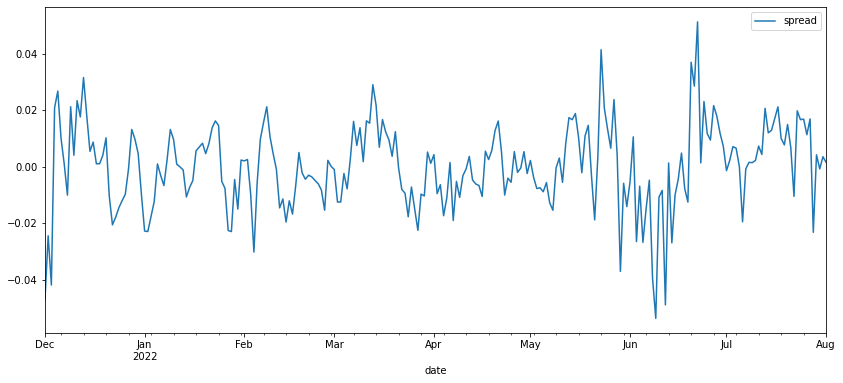

In [33]:
spread = spreads[best_idx].to_frame().rename(columns={best_idx: "spread"})
spread[:train_end].plot(figsize=(14, 6));

We can now proceed the calculate the in-sample and out-of-sample PnL of our chosen portfolio, with transanction costs. Assumptions:

1. Commission and slippage are 0.075% and 0.2% per trade respectively
2. Funding rates (short rental) are 7% per annum

The optimal threshold to trade the spread is numerically calculated by following the methodology outlined in "Finding the Optimal Pre-set Boundaries for Pairs Trading Strategy Based on Cointegration Technique" by H. Puspaningrum et al (2009)

Reference: https://ro.uow.edu.au/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1040&context=cssmwp

In [34]:
mrp_pnl = calculate_pnl_from_spread(spread, train_start, train_end, test_end)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.85it/s]


Assets used: ['TRXUSDT', 'SNXUSDT', 'ENSUSDT', 'ZILUSDT', 'CHRUSDT', 'XMRUSDT', 'MTLUSDT', 'NEARUSDT', 'TRBUSDT', 'BLZUSDT', 'CRVUSDT', 'ATOMUSDT', 'WAVESUSDT', 'BELUSDT', 'RSRUSDT', 'EGLDUSDT', 'GALAUSDT', 'ARUSDT', 'MKRUSDT', 'CTKUSDT', 'ALGOUSDT']


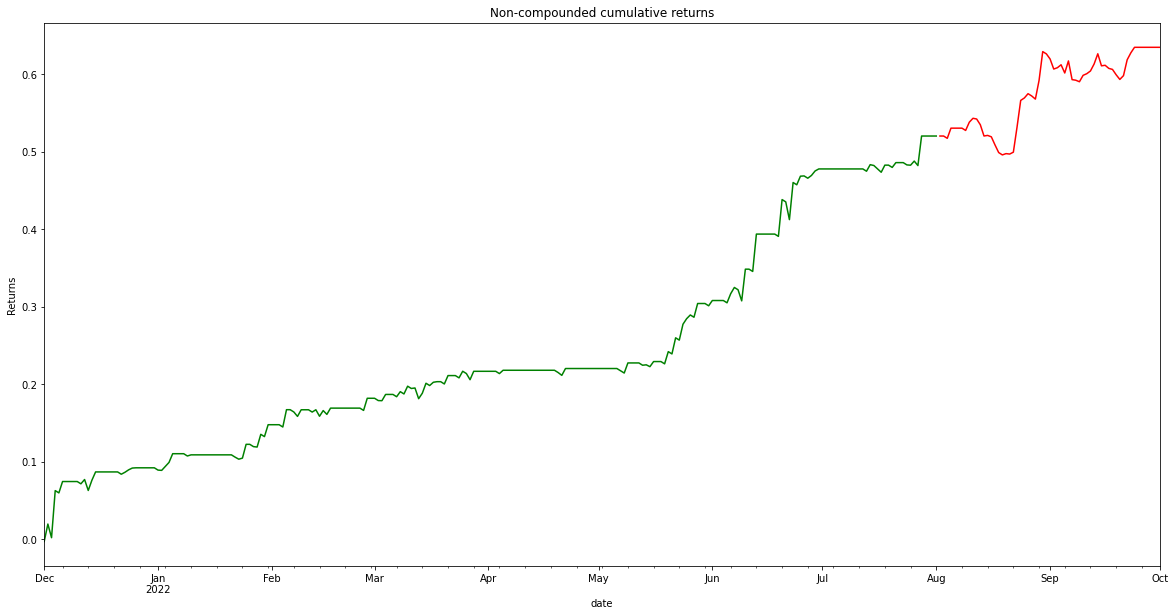

In [35]:
plt.figure(figsize=(20,10))
pf.plot_returns(mrp_pnl.cumsum(), live_start_date=test_start)
plt.title("Non-compounded cumulative returns");
print(f"Assets used: {portfolio_assets}")

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.64,2022-08-11,2022-08-19,2022-08-24,10
1,3.87,2022-08-30,2022-09-09,2022-09-24,19
2,2.58,2022-06-20,2022-06-22,2022-06-23,4
3,1.76,2021-12-02,2021-12-03,2021-12-04,2
4,1.73,2022-06-07,2022-06-09,2022-06-10,4


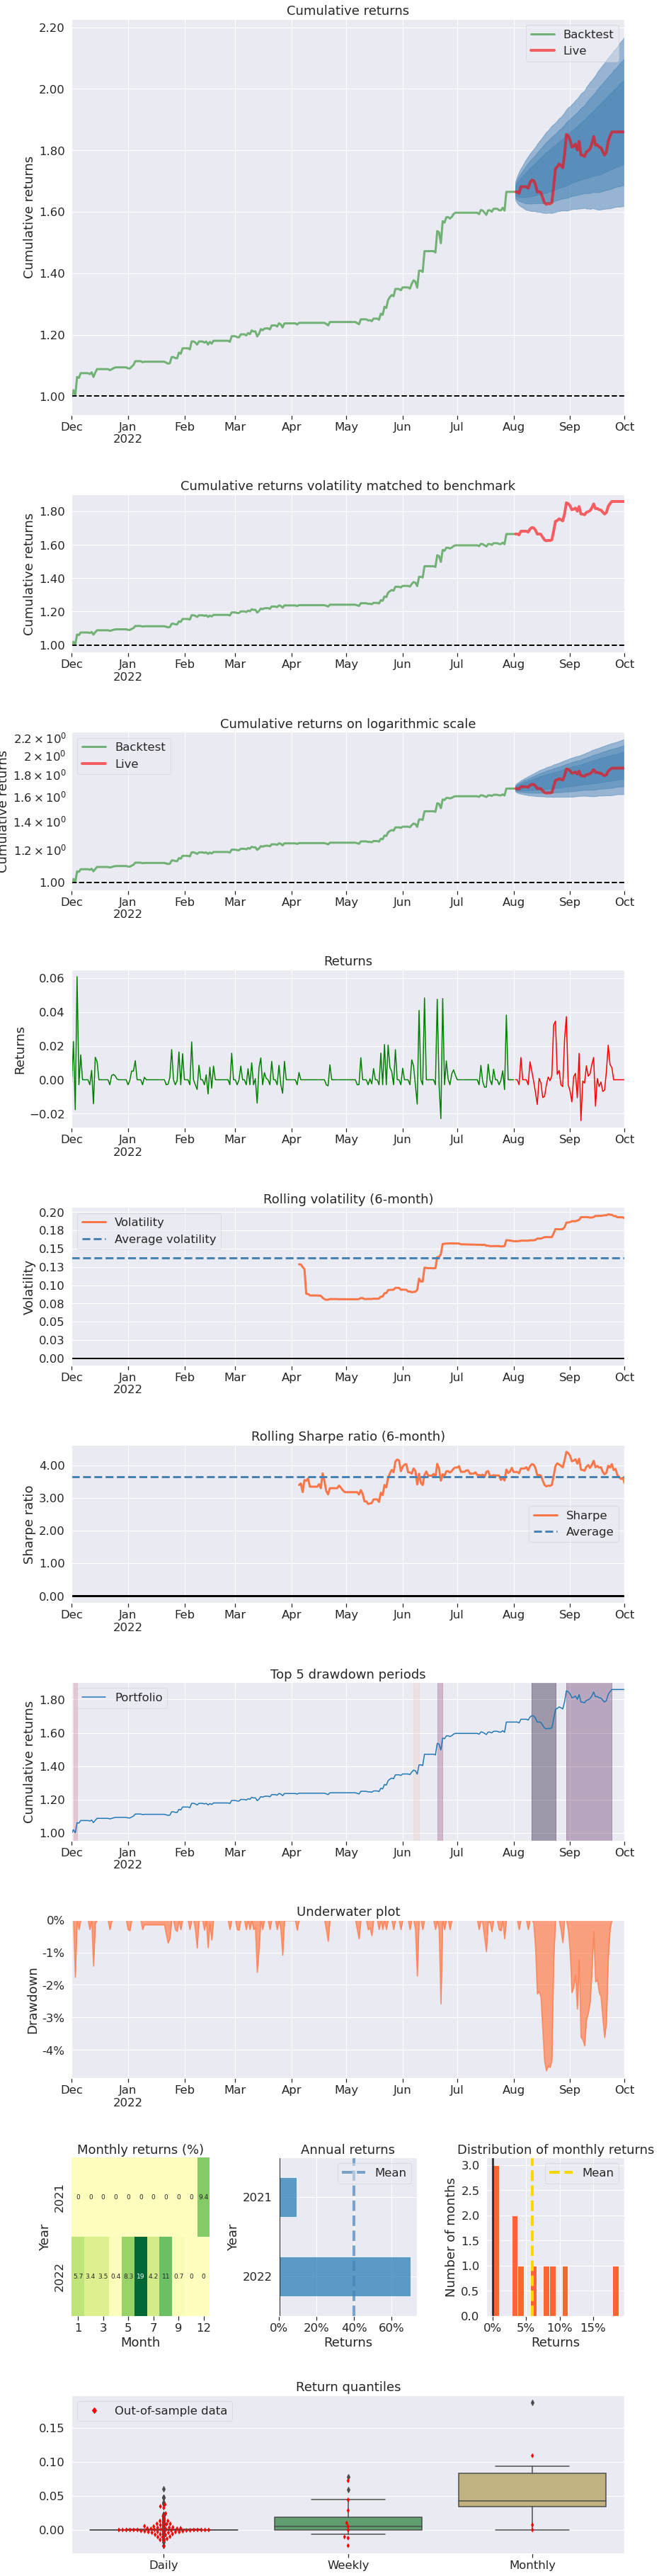

In [36]:
pf.create_returns_tear_sheet(mrp_pnl, live_start_date=test_start)

From our results, it is evident that this method is indeed able to produce mean-reverting portfolios that perform well in-sample and out-of-sample. We can now proceed to construct an optimal portfolio with the VECM approach.

## Vector Error Correction Model (VECM)

In [37]:
asset_prices = close[portfolio_assets[:12]].dropna() # First 12 assets, as VECM can only handle up to a maximum of 12 assets
log_prices = asset_prices.apply(np.log)
is_prices = log_prices[train_start:train_end]
is_prices = is_prices.sub(is_prices.mean(axis=0))

In [38]:
maxlags = int(12*(len(is_prices)/100)**(1/4)) # Default as outlined in statsmodels' documentation

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lags = select_order(is_prices, maxlags=maxlags, deterministic="co")
    order = lags.selected_orders['bic']
    cj = coint_johansen(is_prices, det_order=0, k_ar_diff=order)

In [39]:
eigenvectors = []
for i in range(cj.evec.shape[1]):
    eigenvector = pd.Series(cj.evec[:, i])
    eigenvectors.append(eigenvector)

In [40]:
cv_eigen = cj.cvm[:, 0]
cv_trace = cj.cvt[:, 0]

print(f"Critical value of maximum eigenvalue statistic at 95% confidence: {cv_eigen[1]}")
print(f"Critical value of trace statistic at 95% confidence: {cv_trace[1]}")

Critical value of maximum eigenvalue statistic at 95% confidence: 67.1307
Critical value of trace statistic at 95% confidence: 277.374


In [41]:
ev_stat = cj.lr2
trace_stat = cj.lr1
print(f"VECM eigenvalue statistic: {ev_stat}")
print("\n")
print(f"VECM trace statistic: {trace_stat}")

VECM eigenvalue statistic: [85.67390707 49.23824792 46.45524848 38.10606377 37.37783844 23.43455559
 21.63061466 12.85183128 10.52348375  6.88935361  5.98572218  1.72164185]


VECM trace statistic: [339.88850858 254.21460151 204.97635359 158.52110511 120.41504134
  83.0372029   59.60264731  37.97203265  25.12020138  14.59671763
   7.70736402   1.72164185]


In [42]:
# We compare the eigen and trace statistics to their respective values at a 95% confidence level
# Each statistic that is greater than their critical value represents a cointegrating relationship
coint_eigen = [i for i in ev_stat if i > cv_eigen[1]]
coint_trace = [i for i in trace_stat if i > cv_trace[1]]
print(coint_eigen)
print(coint_trace)

print(f"Number of cointegrating relationships: {len(coint_trace)}")

[85.6739070665665]
[339.8885085773379]
Number of cointegrating relationships: 1


In [43]:
beta = pd.concat(eigenvectors, axis=1)
beta = beta.div(beta.abs().sum(0))
beta = beta.div(beta.iloc[0, :])
beta = beta.div(beta.abs().sum(axis=0))
beta

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.292668,0.014648,0.094837,0.191377,0.012288,0.074614,0.071699,0.076822,0.051724,0.231417,0.056255,0.057469
1,-0.013022,-0.095055,-0.068190,0.228274,0.085857,-0.066121,0.035999,-0.156026,0.090398,-0.071169,0.061605,0.044813
2,-0.054603,-0.153166,-0.064770,-0.061969,-0.098577,0.060362,-0.064311,0.009290,-0.012281,0.138720,-0.064756,-0.080272
3,-0.034113,0.025691,0.034327,-0.044190,-0.120524,0.014595,0.048807,0.086933,0.084437,-0.151709,0.077229,-0.100128
4,-0.015680,0.140396,-0.036838,-0.043950,0.157513,0.148853,-0.050736,-0.232218,0.173584,-0.038082,0.030146,-0.176537
5,-0.159771,0.092285,-0.093061,-0.012921,0.113816,0.148422,0.147078,-0.008659,-0.197248,-0.025445,-0.254898,-0.116553
6,0.087690,-0.081832,0.202354,-0.072022,0.085854,-0.080125,-0.052510,-0.110884,-0.040878,-0.019480,-0.070620,-0.042607
7,0.108791,-0.080714,-0.104661,-0.012705,0.029695,-0.039575,-0.187268,0.102207,-0.093089,-0.009510,0.073755,0.110060
8,0.092625,0.019071,-0.058213,-0.127143,0.048484,-0.038016,0.093571,0.008798,-0.013902,-0.048175,-0.030181,-0.032076
9,-0.053970,0.082367,-0.027208,0.100914,-0.100042,-0.038101,-0.062268,-0.015540,-0.191894,0.037264,0.137723,0.049404


In [44]:
spreads = pd.DataFrame(log_prices.to_numpy()@beta.to_numpy(), index=log_prices.index)
spreads = spreads[train_start:test_end].sub(spreads[train_start:train_end].mean(axis=0))
z_scores = spreads.div(spreads[:train_end].std(axis=0))
z_scores

,0,1,2,3,4,5,6,7,8,9,10,11
date,,,,,,,,,,,,
2021-12-01,-0.068624,1.047325,0.504648,0.623562,-0.360562,0.530376,1.022702,-2.772732,0.449308,0.391080,-1.648147,-3.070260
2021-12-02,0.102415,0.882916,1.175291,0.410541,-0.369461,1.115019,1.741047,-2.879747,0.298767,0.525554,-1.829939,-3.069530
2021-12-03,1.652840,-0.102262,1.850901,0.157469,-1.168776,1.217479,1.803210,-2.552262,0.094013,0.743738,-1.372959,-2.224674
2021-12-04,-0.000247,-0.876613,0.760525,-0.224858,-1.344227,1.303195,1.595439,-2.039094,0.685217,0.987580,-1.533746,-2.033728
2021-12-05,-1.159620,-0.809029,0.068736,-0.326028,-1.266905,0.909654,1.446943,-1.584844,0.790823,0.934167,-1.758391,-2.033539
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27,-3.191399,-3.542524,-1.139729,-3.655435,-3.628190,1.969083,2.997257,1.303136,-1.202706,2.523772,-0.778072,0.100157
2022-09-28,-3.590837,-3.525980,-1.791631,-3.120121,-3.245683,1.615264,3.032317,1.140680,-1.175695,2.398930,-0.848329,0.042430
2022-09-29,-3.168000,-3.459665,-1.646266,-3.054377,-3.052759,1.790038,2.979481,1.122656,-1.129394,2.447766,-0.852953,-0.032613


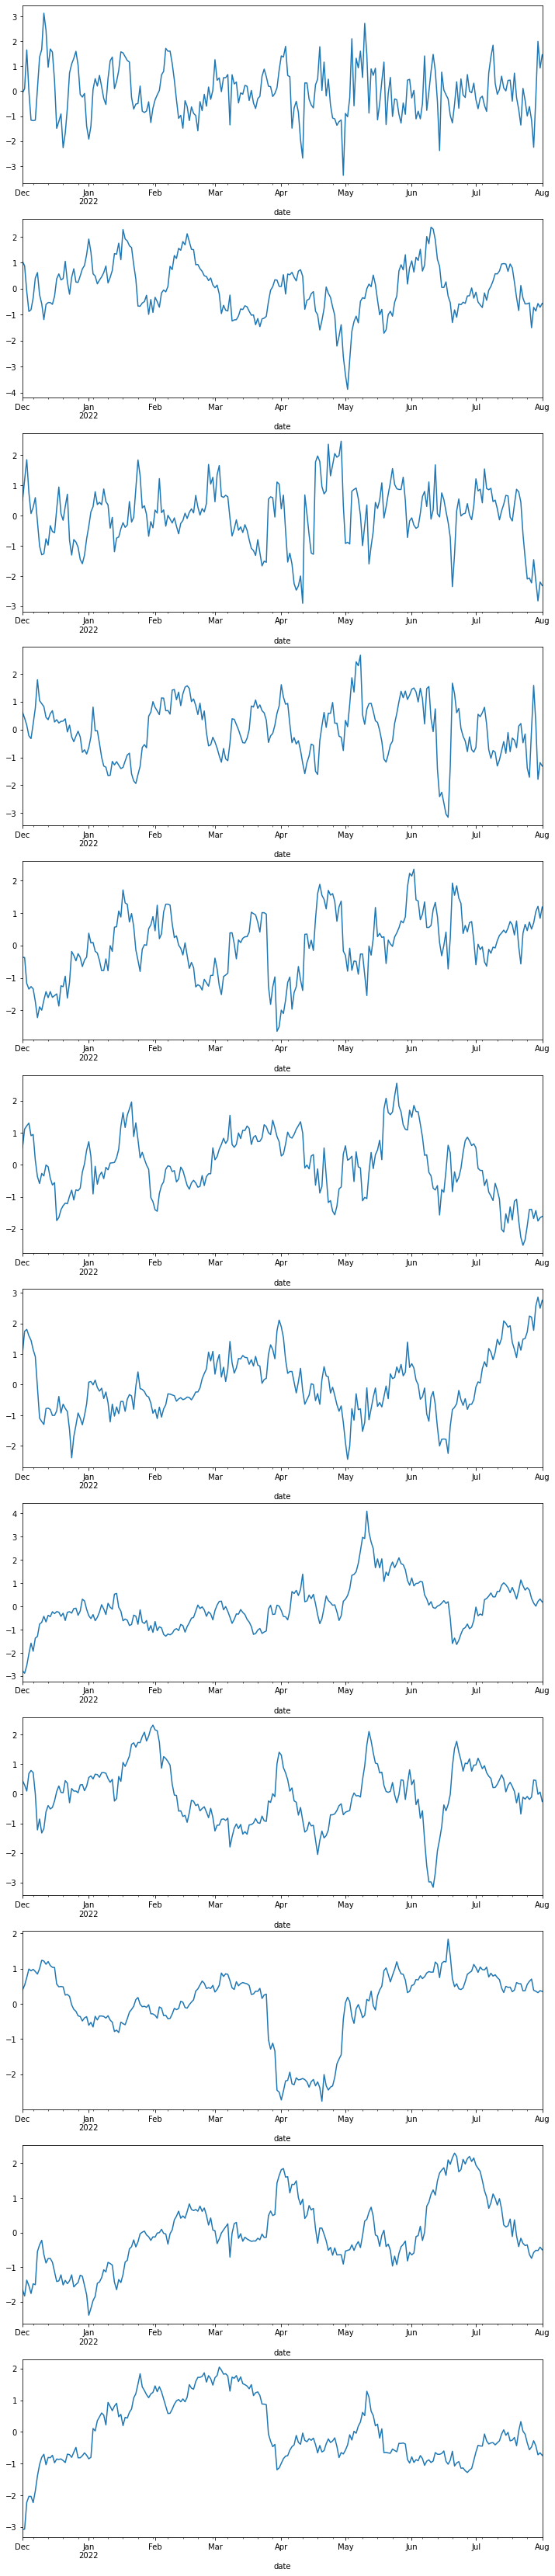

In [45]:
fig, ax = plt.subplots(z_scores.shape[1], 1, figsize=(12, z_scores.shape[1]*5))
for i in range(z_scores.shape[1]):
    z_scores[i][train_start:train_end].plot(ax=ax[i]);

In [46]:
port_stat, indices = [], []
for i in range(z_scores.shape[1]):
    s = spreads.iloc[:, i][:train_end].to_numpy()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        if stationarity_test(s):
            ps = portmanteau_statistic(s)
            port_stat.append(ps)
            indices.append(i)

stat_df = pd.DataFrame(port_stat, index=indices).rename(columns={0: "Portmanteau statistic"})
stat_df["Predictability statistic"] = predictability_statistic(z_scores[:train_end][stat_df.index])
stat_df["Crossing statistic"] = crossing_statistic(z_scores[:train_end][stat_df.index])
stat_df["Drift statistic"] = drift_statistic(z_scores[:train_end][stat_df.index])
stat_df = stat_df.dropna()
stat_df

,Portmanteau statistic,Predictability statistic,Crossing statistic,Drift statistic
0,121.564778,0.296254,3.165388,0.138889
1,578.127423,0.797460,6.693323,0.194444
2,270.164019,0.575357,4.480400,0.055556
3,354.254386,0.693741,5.372560,0.083333
4,579.201561,0.760372,6.190078,0.250000
5,668.757269,0.821819,7.380135,0.166667
6,663.988176,0.842409,8.208213,0.222222
8,725.536611,0.882145,8.935562,0.111111


In [47]:
sorted_stats = stat_df.prod(axis=1).sort_values()
best_idx = sorted_stats.index[1]
print(f"Most statistically suitable eigenportfolio: {best_idx}")

Most statistically suitable eigenportfolio: 2


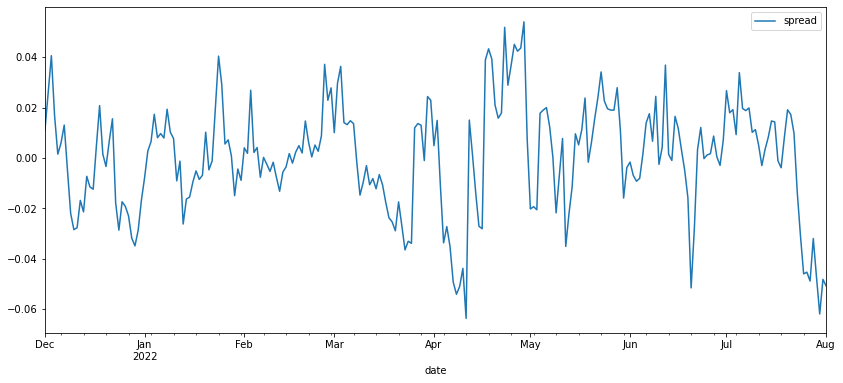

In [48]:
spread = spreads[best_idx].to_frame().rename(columns={best_idx: "spread"})
spread[:train_end].plot(figsize=(14, 6));

In [49]:
mrp_pnl = calculate_pnl_from_spread(spread, train_start, train_end, test_end)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.06it/s]


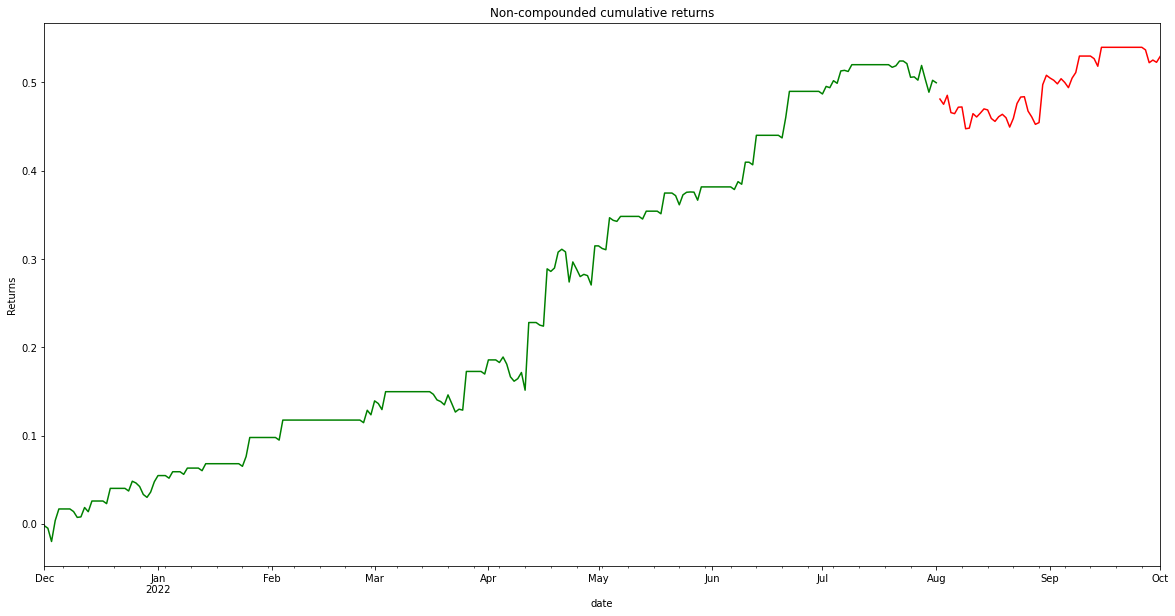

In [50]:
plt.figure(figsize=(20,10))
pf.plot_returns(mrp_pnl.cumsum(), live_start_date=test_start)
plt.title("Non-compounded cumulative returns");

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.51,2022-07-23,2022-08-09,2022-09-09,35
1,4.06,2022-04-21,2022-04-29,2022-04-30,7
2,3.73,2022-04-05,2022-04-11,2022-04-12,6
3,2.30,2022-03-16,2022-03-23,2022-03-26,8
4,1.82,2021-12-25,2021-12-29,2022-01-01,5


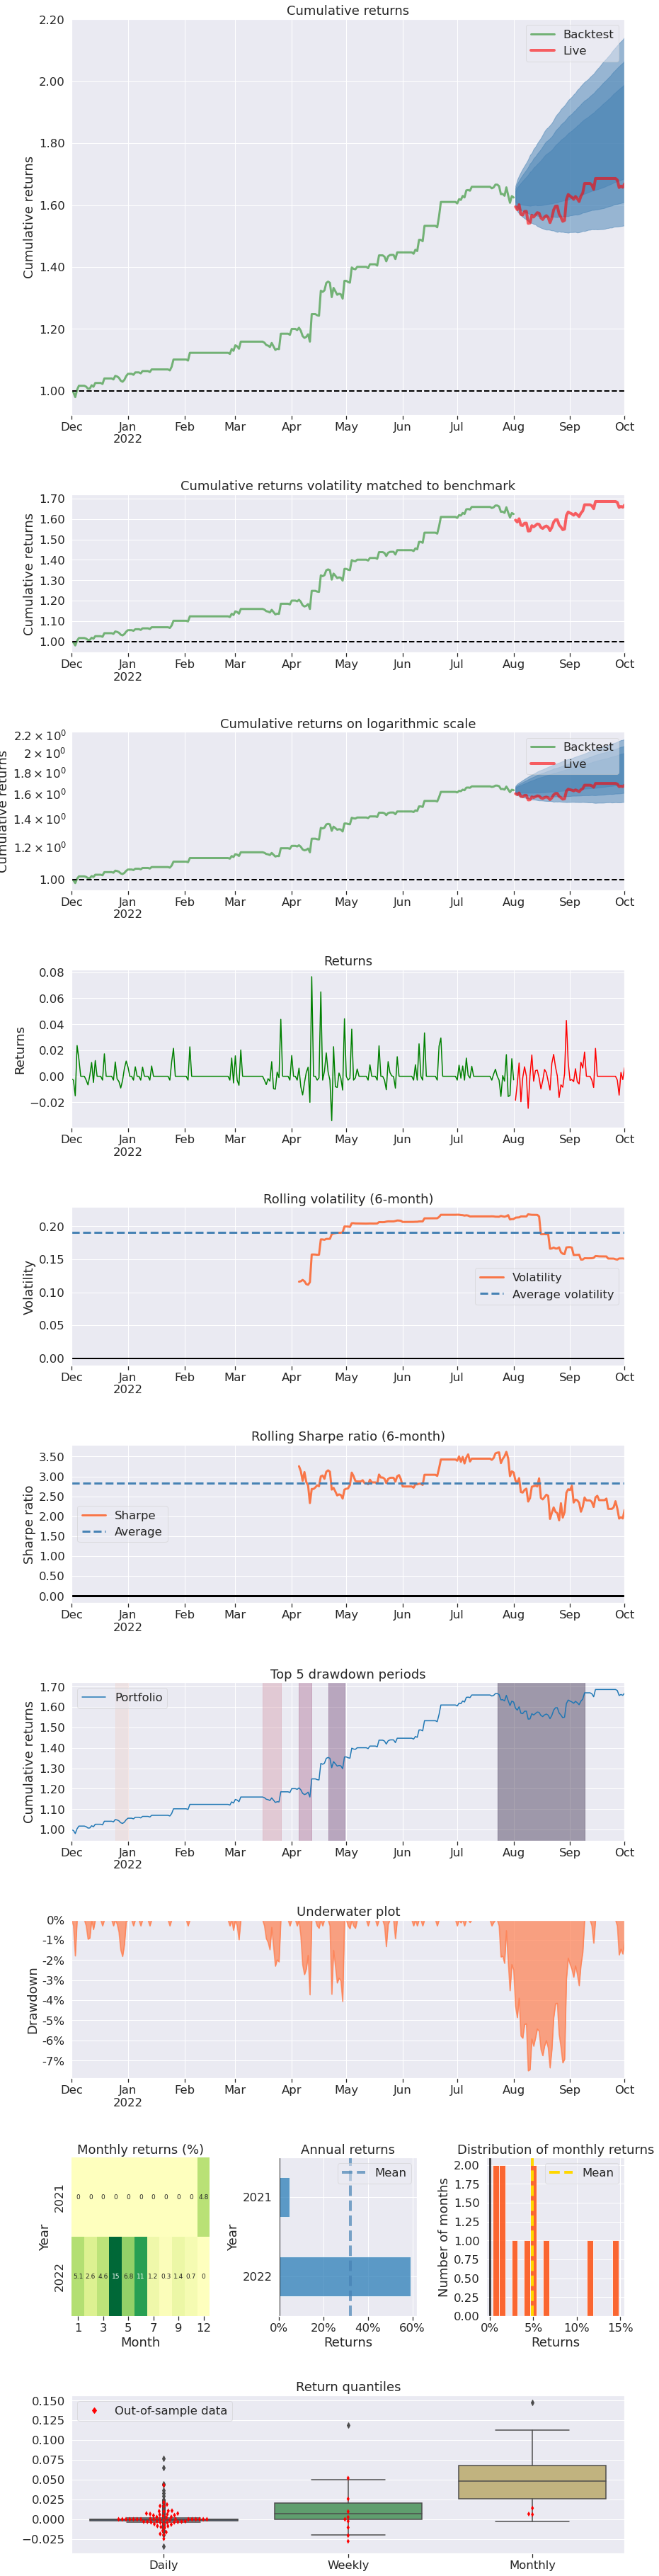

In [51]:
pf.create_returns_tear_sheet(mrp_pnl, live_start_date=test_start)

The VECM approach, while profitable, appears to be worse off than Canonical Analysis.